In [55]:
import os
import sys
import numpy as np
import pickle
import cv2
import torch
import torchvision.models as models

In [42]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compitability with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()
            
        
def get_target_width_height(input_tensor):
    width, height = input_tensor.size(-1), input_tensor.size(-2)
    return width, height

In [5]:
model = models.resnet18(pretrained=True)

In [6]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
import requests
# IMAGENET
img_url = "http://farm2.static.flickr.com/1131/681589138_e4b702f863.jpg"
get_img = requests.get(img_url)

open('test.png', 'wb').write(get_img.content)

79168

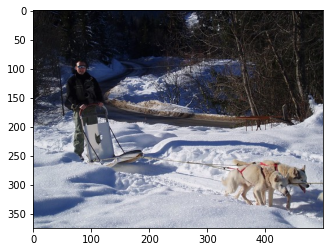

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = 'test.png'

img = Image.open(img_path)

plt.imshow(img)

In [35]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

input_tensor = cvt_tensor(img).view(1, 3, 224, 224)
target_layers = model.layer4
target_category = 537

In [36]:
activations_and_grads = ActivationsAndGradients(model, target_layers, reshape_transform=None)

In [37]:
output = activations_and_grads(input_tensor)

In [38]:
pred = np.argmax(output.cpu().data.numpy())
print(pred)

if isinstance(target_category, int):
    target_category = [target_category] * input_tensor.size(0)
print(target_category)

537
[537]


In [39]:
target_category

[537]

In [40]:
activations_and_grads.activations[0].shape

torch.Size([1, 512, 7, 7])

In [43]:
activations_list = [a.cpu().data.numpy() for a in activations_and_grads.activations]
grads_list = [g.cpu().data.numpy() for g in activations_and_grads.gradients]
target_size = get_target_width_height(input_tensor)

In [46]:
activations_pick = activations_list[0]

In [50]:
activations_pick[np.isnan(activations_pick)] = 0
projections = []

# batch
for activations in activations_pick:
    # reshape
    reshaped_activations = (activations).reshape(
        activations.shape[0], -1).transpose()
    print(reshaped_activations.shape)
    # centering
    reshaped_activations = reshaped_activations - reshaped_activations.mean(axis=0)
    print(reshaped_activations.shape)
    # decomposition
    U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
    print(U.shape)
    print(S.shape)
    print(VT.shape)
    projection = reshaped_activations @ VT[0, :]
    print(projection.shape)
    projection = projection.reshape(activations.shape[1:])
    print(projection.shape)
    projections.append(projection)
    
projections = np.float32(projections)

(49, 512)
(49, 49)
(49,)
(512, 512)
(49,)
(7, 7)


In [96]:
show_image = projections[0]
show_image = show_image - np.min(show_image)
show_image = show_image / (1e-7 + np.max(show_image))
show_image = cv2.resize(show_image, target_size)
show_image = cv2.applyColorMap(np.uint8(255 * show_image), cv2.COLORMAP_JET)
print(show_image.shape)

(224, 224, 3)


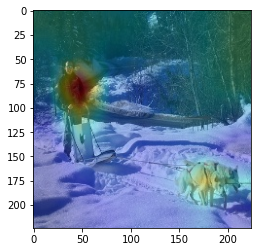

In [97]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, target_size)

heatimg = np.uint8(show_image*0.3 + img*0.7)
plt.imshow(cam_img)